# Short-Time Fourier-Transform (STFT)
Interaktives Notizbuch zur Kurzzeit-Fourier-Transformation in Signale und Systeme

<br>   Autor: Andreas Weber
<br>   Matrikelnummer: 1540399
<br>   Dozent: Prof. Dr. Janko Dietzsch 
<br>   Datum: 28.05.2021

## Notwendige Packages

In [ ]:
# install required dependencies
# !pip install -r requirements.txt

In [1]:
# Verwendete Python Version: Python 3.8.5
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.signal import spectrogram, chirp
import sounddevice as sd
import librosa

from ipywidgets import interact, fixed, IntSlider, FloatSlider
import IPython.display as ipd

sns.set()
plt.rcParams.update({'font.size': 15})

## Motivation
Bei der Signalanalyse von Musik oder Sprache sind oftmals die im Signal enthaltenen Spektralanteile von Interesse,
die einem bestimmten Zeitpunkt oder Zeitintervall zugeordnet werden können.
Ähnlich wie bei einem Notenblatt, bei dem das Lied bezüglich seines spektralen Gehaltes und dessen
zeitlichen Auftretens spezifiziert ist, soll ein Signal analysiert und visualisiert werden [vgl. 2, S. 295ff].

Da die klassische Fourier-Analyse den Spektralanteilen eines Signals keine Zeitintervalle zuordnet,
bedarf es einer Methode zur Zeit-Frequenz-Analyse. Mithilfe der Kurzeit-Fourier-Transformation kann der zeitliche Verlauf des Frequengehaltes eines Signals analysiert werden. Sie ist deshalb ein wichtiger Bestandteil der moderner Sprach- und Audiocodierverfahren
sowie Verfahren zur Sprach- und Sprechererkennung  [vgl. 2, S. 295ff; 8]. 

<img src="img/noten.png" width="400">
<center> Zeitlicher Verlauf des Frequengehaltes eines Signals</center>


## Fehlen der Zeitauflösung in der Fourier-Transformation

Zunächst soll in diesem Beispiel verdeutlicht werden, dass bei der klassischen Fourier-Transformation keine Zeitauflösung erfolgt. Es wird ein zusammengesetztes, sinusförmiges Signal verwendet, dass in der ersten Hälfte der Signalzeit die Frequenz 1 Hz besitzt und ab der zweiten Hälfte eine Frequenz von 4 Hz annimmt. 

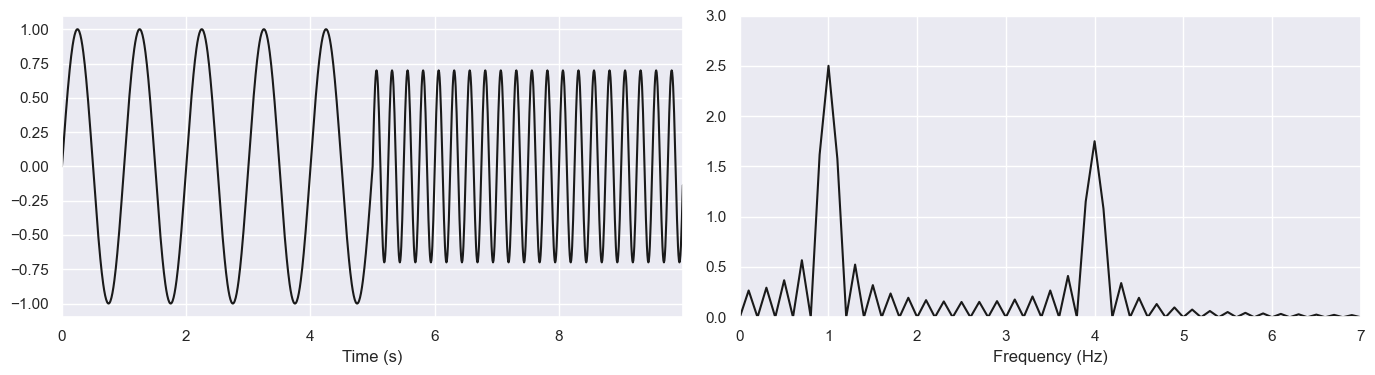

In [2]:
"""
Veranschaulichung der fehlenden Zeitauflösung bei der klassischen Fourier-Transformation

Quelle: In Anlehnung an [7] Missing Time Localisazion

"""
omega1 = 1
omega2 = 4

samplesPerSecond = 128
duration = 10
totalSamples = int(duration * samplesPerSecond)

t = np.arange(totalSamples) / samplesPerSecond

t1 = t[:totalSamples//2]
t2 = t[totalSamples//2:]


# combine two different signals
signalFirst = 1.0 * np.sin(2 * np.pi * omega1 * t1)
signalSecond = 0.7 * np.sin(2 * np.pi * omega2 * t2)
signal = np.concatenate((signalFirst, signalSecond))


plt.figure(figsize=(14, 4))
# Signal Plot
plt.subplot(1, 2, 1)
plt.plot(t, signal, c='k')
plt.xlim([min(t), max(t)])
plt.xlabel('Time (s)')

# Frequency Plot
plt.subplot(1, 2, 2)
X = np.abs(np.fft.fft(signal)) / samplesPerSecond # Compute the 1-D discrete Fourier Transform
freqency = np.fft.fftfreq(totalSamples, d=1/samplesPerSecond)
X = X[:totalSamples//2]
freqency = freqency[:totalSamples//2]
plt.plot(freqency, X, c='k')
plt.xlim([0, 7])
plt.ylim([0, 3])
plt.xlabel('Frequency (Hz)')
plt.tight_layout()

## Definition der Kurzzeit-Fourier-Transformation

Dennis Gabor stellte im Jahre 1946 die *Kurzzeit-Fourier-Transformation* (engl. Short-Time Fourier-Transform [STFT]) vor, die die Möglichkeit bietet, ein Signal gleichzeitig auf seine zeitlichen und spektralen Aspekte zu untersuchen. Die Kurzzeit-Fourier-Transformation ist damit eine zentrale Methode der Zeit-Frequenz-Analyse. Sie bildet den Schritt von einer reinen, nicht zeitabhängigen Fourieranalyse zu einer Repräsentation, die das lokale Frequenzverhalten eines Signals zeigt.








### Zeitkontinuierliche STFT
Das zu analysierende Signal $x(t)$ wird mit einem Analysefenster $\gamma^*(t-\tau)$ multipliziert und das Ergebnis  wird fouriertransformiert [2, S. 295].

 $$ X(\tau, \omega) = \int_{-\infty}^{\infty} x(t)\cdot\gamma^*(t-\tau) \cdot e^{- j\omega t} \,dt  $$

### Zeitdiskrete STFT
In der digitalen Signalverarbeitung liegt bei einer realen Messungen - im Gegensatz zu einer Simulation - das Signal als Folge einzelner Abtastwerte vor. Bei dieser Zeit-Frequenz-Analyse wird auf die Abtastwerte eine diskrete Fensterfunktion $\gamma[t-m]$ angewendet und das Ergebnis einer diskreten Fourier-Transformation vollzogen [8].

 $$ X(m, \omega) = \sum\limits_{n=-\infty}^{\infty} x(t)\cdot\gamma[n-m] \cdot e^{- j\omega n}  $$

## Fensterung eines Signals

Die *Fensterfunktion* $\gamma^*(t-\tau)$ ist in der Regel eine gut zeitlokalisierte Funktion, wobei $\tau$ den betrachteten Analysezeitpunkt angibt. Anstatt der konjugiert komplexen Fensterfunktion $\gamma^*$ kann für den üblichen Fall eine reelle Fensterfunktion verwendet werden, sodass $\gamma = \gamma^*$ [vgl. 2, S. 296].

Das Analysefenster wird entlang der Zeitachse verschoben und unterdrückt das Signal $x(t)$ außerhalb eines bestimmten Bereiches. Dies bewirkt, dass das Signal schrittweise zu den Zeitpunkten $t = \tau$ einer gefensterten Fourier-Transformation unterzogen wird. Das Ergebnis liefert für den jeweiligen Zeitpunkt ein lokales Spektrum [vgl. 6]. 

<img src="img/fensterung.jpg" width="500">
<center> Prinzip der Kurzzeit-Fourier-Transformation [6]</center>

Die Anwendung der Fourier-Transformation auf ein gefenstertes Signal, soll durch folgendes interaktives Beispiel nachvollzogen werden können. Es ist anzumerken, dass in diesem Beispiel eine rechteckige Fensterfunktion verwendet wurde.

In [3]:
def windowedFT(t, signal, samplesPerSecond, windowPosInSeconds, windowLen):
    """
    Anwendung der Fourier-Transformation auf einen gefensterten Bereich des Signals
    Source: In Anlehnung an [7]
    """
    
    signalLen = len(signal)
    windowPos = int(samplesPerSecond * windowPosInSeconds)
    wPadded = np.zeros(signalLen)
    wPadded[windowPos:windowPos + windowLen] = 1 # create window of size windowLin at start pos windowPos
    wSignal = signal * wPadded # windowed Singal
    
    
    plt.figure(figsize=(8, 2))
    
    # plot windowed signal
    plt.subplot(1, 2, 1)
    plt.plot(t, wSignal, c='k')
    plt.plot(t, wPadded, c='r')
    plt.xlim([min(t), max(t)])
    plt.ylim([-1.1, 1.1])
    plt.xlabel('Time (s)')

    # plot windowed fourier transformed signal
    plt.subplot(1, 2, 2)
    X = np.abs(np.fft.fft(wSignal)) / samplesPerSecond #Compute the 1-D discrete Fourier Transform
    frequency = np.fft.fftfreq(signalLen, d=1/samplesPerSecond)
    X = X[:signalLen//2]
    frequency = frequency[:signalLen//2]
    plt.plot(frequency, X, c='k')
    plt.xlim([0, 7])
    plt.ylim([0, 3])
    
    plt.xlabel('Frequency (Hz)')
    plt.tight_layout()
    plt.show()

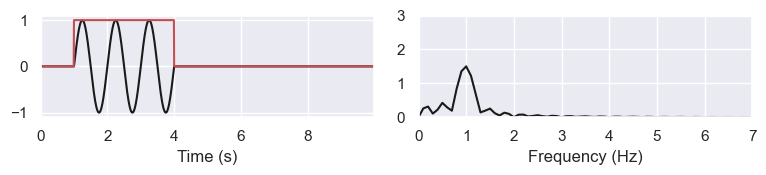

In [4]:
wLen = 3* samplesPerSecond
windowedFT(t, signal, samplesPerSecond, windowPosInSeconds=1, windowLen=wLen)
windowedFT(t, signal, samplesPerSecond,windowPosInSeconds= 6, windowLen=wLen)


In [5]:
print('Interaktive Verschiebung der Fensterfunktion: ')
interact(windowedFT,
         windowPosInSeconds=FloatSlider(min=0, max=duration-(wLen/samplesPerSecond), step=0.1, 
                continuous_update=False, value=2, description='Position'),
                t=fixed(t), signal=fixed(signal), samplesPerSecond=fixed(samplesPerSecond), windowLen=IntSlider(min=1*samplesPerSecond, max=5*samplesPerSecond, step=samplesPerSecond, 
                continuous_update=False, value=3*samplesPerSecond, description='Len(samples)'));

Interaktive Verschiebung der Fensterfunktion: 


interactive(children=(FloatSlider(value=2.0, continuous_update=False, description='Position', max=7.0), IntSli…

Es ist zu sehen, dass die STFT abhängig von der Länge des Fensters ist. Außerdem wirkt sich die Form der Fensterfunktion ebenfalls auf das Ergebnis aus. Die Wahl einer rechteckigen Fensterfunktion wie im obigen Beispiel, stellt einen einfachen Weg dar, das Signal in einem bestimmten Bereich zu lokalisieren und außerhalb zu unterdrücken. Allerdings führt die abrupte Änderung des Rechtecksignals an den Abschnittsgrenzen zu gewissen Welligkeiten im Ergebnis der Fourier-Transformation. Um die Randeffekte abzuschwächen, werden daher meist Fensterfunktionen verwendet, die an den Abschnittsgrenzen einen sanfteren Übergang zu Null aufweisen [vgl 7].

## Zeit-Frequenz-Auflösung
Die Fensterung des Signals im Zeitbereich führt gleichzeitig zu einer Fensterung des Signals im Spektralbereich. Die Größe $ X(\tau, \omega)$ enthält somit Informationen über das Signal $x(t)$ und dessen Spektrum $ \Gamma(\omega)$ in dem betrachteten Zeit-Frequenz-Fenster. Die Lage des Zeit-Frequenz-Fenster ist abhängig von den Parametern $\tau $ und $\omega$. Bei der Zeit-Frequenz-Analyse besteht das Bestreben eine hohe Zeit- als auch Frequenzauflösung zu erreichen. Allerdings ist dies nur begrenzt umsetzbar, denn es gilt die Unschärferelation [vgl. 2].

### Unschärferelation
Die Unschärferelation setzt eine untere Schranke für die  Fläche des Zeit-Frequenz-Fensters. Das Ziel eine möglichst kleine Fläche für das Zeit-Frequenz-Fenster zu erhalten, ist dadurch limitiert. 
Ein langes Fenster bietet zwar eine gute Frequenzauflösung, weist jedoch unweigerlich eine schlechte Zeitauflösung  auf (siehe I). Im Gegenzug folgt aus einem kurzen Fenster eine gute Zeitauflösung, jedoch mit einer schlechten Frequenzauflösung (siehe II) [vgl. 2, 5].



<img src="img/Zeit-Frequenz_Auflösung.png" width="800">
<center> Zusammenhang zwischen Zeit und Frequenzauflösung [vgl. 5]</center>

Die Unschärferelation ist gegeben durch $\Delta_t \Delta_{\omega} \geq \frac{1}{2} $. Für eine ausführliche Herleitung wird auf [2, S. 231f] verwiesen.

### Darstellung

Da das Ergebnis der Kurzzeit-Fourier-Transformation im Allgemeinen komplexwertig ist, wird für dessen grafische Darstellung das Betragsquadrat verwendet. Diese Darstellung bezeichnet man auch als Spektrogramm.

$$ S_x(\tau, \omega) = \bigl|  X(\tau, \omega) \bigl|^2  = \biggl|\int_{-\infty}^{\infty} x(t)\cdot\gamma^*(t-\tau) \cdot e^{- j\omega t} \,dt \biggl|^2$$


#### Beispiel 1: Sinussignal mit zwei verschiedenen Frequenzen

Das erste Beispiel soll Bezug zur vorhergehenden sinusförmigen Funktion mit zwei unterschiedlichen Frequenzen herstellen. Bis Sekunde fünf besitzt das Signal eine Frequenz von 1 Hz und wird danach auf 4 Hz erhöht. Das dargestellte Bild "Zeit Frequenz-Auflösung eines Signals" zeigt das ursprüngliche Signal (oben) mit der dazugehörigen Zeit-Frequenz-Darstellung in einem Spektrogram (unten). Die Werte $S_x(\tau, \omega)$ werden durch unterschiedliche Graustufen repräsentiert. 


In [6]:
def plot_spectrogram(signal, samplesPerSecond, omegaMax, title, nperseg =256, nfft=256 ):
    """plot_spectrogram
    Function to plot a Sepktrogram
    
    Params:
        signal: the given Signal
        samplesPerSecond: frequency of sampling
        omegaMax: max Frequency of Singal 
        nperseg: Length of each segment
        nfft: Length of the FFT, must be greater or equal nperseg
    
    Params of Spectogram:
        ff: Array of sample frequencies
        tt: Array of segment times
        Sxx: Spectrogram of signal
        
    """
    
    ff, tt, Sxx = spectrogram(signal, fs=samplesPerSecond,  nperseg=nperseg, nfft=nfft)
    plt.pcolormesh(tt, ff, Sxx, cmap='gray_r', shading='gouraud')
    if title:
        plt.title("Window Size = " + str(round(nperseg/samplesPerSecond, 2)) + "s")
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.ylim(0, 1.5*omegaMax )

Die Unschärfe der Kurzzeit-Fourier Transformation soll durch folgendes Spektrogramm dargestellt werden.

In [7]:
omega1 = 1
omega2 = 4

samplesPerSecond = 128
duration = 10
totalSamples = int(duration * samplesPerSecond)

t = np.arange(totalSamples) / samplesPerSecond

t1 = t[:totalSamples//2]
t2 = t[totalSamples//2:]


# combine two different signals
signalFirst = 1.0 * np.sin(2 * np.pi * omega1 * t1)
signalSecond = 0.7 * np.sin(2 * np.pi * omega2 * t2)
signal = np.concatenate((signalFirst, signalSecond))

plt.figure(figsize=(10, 4))

# Signal Plot
plt.subplot(2, 1, 1)
plt.title("Zeit Frequenz-Auflösung eines Signals")
plt.plot(t, signal, c='k')
plt.ylabel('Signal')

# Time-Frequency Plot
plt.subplot(2, 1, 2)
plot_spectrogram(signal, samplesPerSecond, omega2, title=False)


Durch Veränderung der Segmentgröße des Fensters kann die Zeit- beziehungsweise die Frequenzauflösung in ihrer Genauigkeit verändert werden. 

- Kleinen Segmentgröße $\leftrightarrow$  gute Zeitauflösung / schlechte Frequenzauflösung
- Große Segmentgröße $\leftrightarrow$  schlechte Zeitauflösung / gute Frequenzauflösung

Im Folgenden ist dieser Zusammenhang durch das Beispiel dargestellt.


Veranschaulichung der Unschärfe der Kurzzeit-Fourier Transformation: 


interactive(children=(IntSlider(value=400, continuous_update=False, description='Segmentgröße', max=512, min=6…

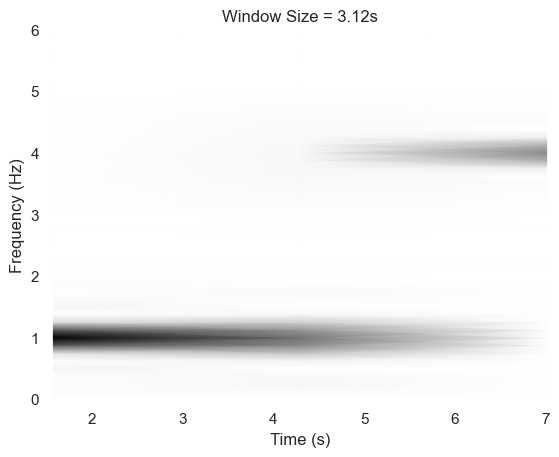

In [8]:
print('\nVeranschaulichung der Unschärfe der Kurzzeit-Fourier Transformation: ')

interact(plot_spectrogram,
         signal=fixed(signal), 
         samplesPerSecond=fixed(samplesPerSecond),
         omegaMax=fixed(omega2),
         title=fixed(True),
         nperseg=IntSlider(min=64, max=512, step=1, 
                continuous_update=False, value=400, description='Segmentgröße'),       
         nfft=fixed(1024));

#### Beispiel 2: Chirp Signal
In Beispiel 2 wird ein frequenzmoduliertes Chirp-Signal erzeugt. Zu Beginn besitzt das sinusförmige Signal die Frequenz $f_0 = 10Hz$. Diese steigt linear innerhalb von zwei Sekunden auf die Frequenz $f_1 = 400 Hz$ an.

In [9]:
def plot_colored_spectogram(x, samplesPerSecond , yMaxF, figSize=None, nfft=128, noverlap=120):
    """plot_colored_spectogram
    Function to plot a colored Sepktrogram in a spezific size 
    
    Params:
        x: the given Signal
        samplesPerSecond: frequency of sampling
        figSize (optional):
        nfft (optional): Length of the FFT
        noverlap (optional):
    """
    
    if figSize:
        plt.figure(figsize=figSize)
    plt.specgram(x, NFFT=nfft, Fs=samplesPerSecond, noverlap=120, cmap='jet_r', scale='dB')
    plt.colorbar(label="Power/Frequency (dB/Hz)")
    plt.ylabel("Frequency (Hz)")
    plt.xlabel("Time (s)")
    plt.ylim((0, yMaxF))

In [10]:
samplesPerSecond = 1000
duration = 2
totalSamples = int(duration * samplesPerSecond)

t = np.arange(totalSamples) / samplesPerSecond
f0 = 10
f1 = 400
x_chirp = chirp(t, f0=f0, f1=f1, t1=duration, method='linear')


plt.figure(figsize=(17, 4))
# Time Plot
plt.subplot(1, 2, 1)
plt.plot(t, x_chirp)
plt.xlabel("Time (s)")
plt.ylabel("Signal")

# Frequency Plot
plt.subplot(1, 2, 2)
plot_colored_spectogram( x_chirp, samplesPerSecond, yMaxF=500,nfft=128, noverlap=120)

print("Vergleich des Signal mit seinem dazugehörigen Spektrogram:")

Vergleich des Signal mit seinem dazugehörigen Spektrogram:


Das dargestellte Chirp-Signal kann mithilfe des Python Moduls "Sounddevice" abgespielt werden. Für Menschen hörbare Signale besitzen ein Frequenzband zwischen (16) 20 Hz bis 18 (20) kHz. Daher ist das "Zwitschern" des linear frequenzmodulierten Signals gut hörbar [vgl. 8].

In [11]:
# Chirp Signal Abspielen
sd.play(x_chirp, samplesPerSecond)

#### Beispiel 3: Musik als Signal

Abschließend werden drei verschiedene Spektogramme von Musiksignalen dargestellt, um die Signalanalyse an Praxisbeispielen aufzuzeigen. Das menschliche Ohr empfindet ein akustisches Signal als Ton, falls ihm eine frequenzmäßige Zuordnung gelingt. Treten unterschiedliche Frequenzen in einem bestimmten Verhältnis zueinander auf, kann ein Signal zusätzlich als harmonisch empfunden werden. Musik setzt sich aus der Kombination verschiedener Töne zusammen. Im Spektogramm können die verschiedene Töne die zu einem bestimmten Zeitpunkt auftreten, dargestellt werden. In den Beispielen ist die Grundfrequenz mit den dazugehörigen Oberwellen eines jeweiligen Tones gut erkennbar. 



In [12]:
# Sound Data
saxo = "audio/saxo1.wav"
guitar = "audio/guitar.wav"
piano = "audio/piano.wav"

Spektrogram von Tönen eines Saxophones


interactive(children=(IntSlider(value=3000, continuous_update=False, description='Max Frequenz', max=11000, mi…

<function __main__.plot_colored_spectogram(x, samplesPerSecond, yMaxF, figSize=None, nfft=128, noverlap=120)>

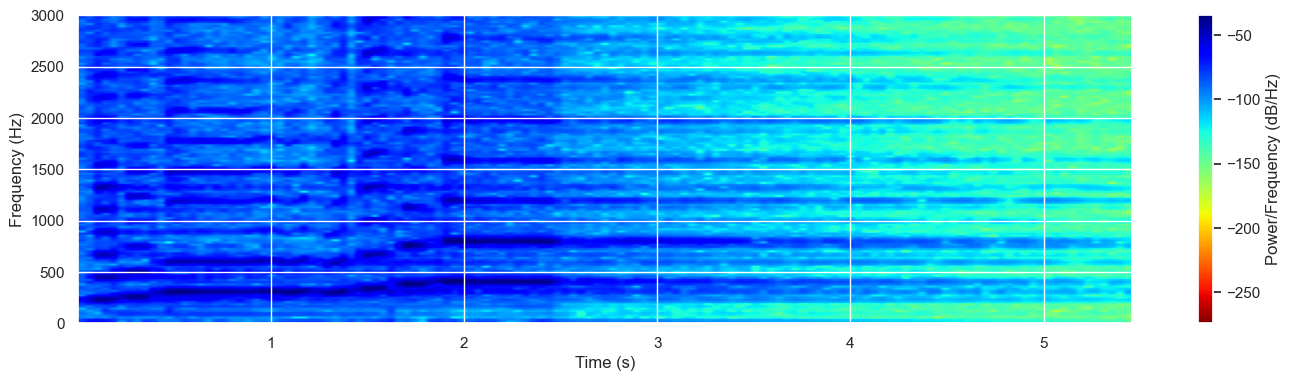

In [15]:
print("Spektrogram von Tönen eines Saxophones")
saxoSignal, saxoSR = librosa.load(saxo)
interact(plot_colored_spectogram,
         x=fixed(saxoSignal), 
         samplesPerSecond=fixed(saxoSR),
         yMaxF=IntSlider(min=2000, max=11000, step=10, 
                continuous_update=False, value=3000, description='Max Frequenz'),       
         noverlap=fixed(200),
         figSize=fixed((17, 4)),
         nfft = IntSlider(min=512, max=11000, step=16, 
                continuous_update=False, value=1024, description='Segmentgröße'))


In [16]:
ipd.Audio(saxo)

In [21]:
print("Spektrogram eines Gitarrenakkords")
guitarSignal, guitarSR = librosa.load(guitar)
interact(plot_colored_spectogram,
         x=fixed(guitarSignal[:guitarSignal.size//2]), 
         samplesPerSecond=fixed(guitarSR),
         yMaxF=IntSlider(min=1000, max=6000, step=10, 
                continuous_update=False, value=3000, description='Max Frequenz'),       
         noverlap=fixed(200),
         figSize=fixed((17, 4)),
         nfft = IntSlider(min=512, max=2048, step=16, 
                continuous_update=False, value=1024, description='Segmentgröße'))

Spektrogram eines Gitarrenakkords


interactive(children=(IntSlider(value=3000, continuous_update=False, description='Max Frequenz', max=6000, min…

<function __main__.plot_colored_spectogram(x, samplesPerSecond, yMaxF, figSize=None, nfft=128, noverlap=120)>

In [18]:
ipd.Audio(guitar)

In [22]:
print("Spektrogram Tönen eines Klaviers")
pianoSignal, pianoSR = librosa.load(piano)
interact(plot_colored_spectogram,
         x=fixed(pianoSignal), 
         samplesPerSecond=fixed(pianoSR),
         yMaxF=IntSlider(min=2000, max=6000, step=10, 
                continuous_update=False, value=3000, description='Max Frequenz'),       
         noverlap=fixed(200),
         figSize=fixed((17, 4)),
         nfft = IntSlider(min=512, max=4096, step=16, 
                continuous_update=False, value=1776, description='Segmentgröße'))


Spektrogram Tönen eines Klaviers


interactive(children=(IntSlider(value=3000, continuous_update=False, description='Max Frequenz', max=6000, min…

<function __main__.plot_colored_spectogram(x, samplesPerSecond, yMaxF, figSize=None, nfft=128, noverlap=120)>

In [20]:
ipd.Audio(piano)

Anhand der Beispiele können die verschiedenen Klänge der Musikinstrumente interaktiv analysiert werden und die im Spektogramm dargestellten Frequenzen können mit den  dazugehörigen Musikbeispielen angehört werden. Dies macht die Signalanalyse mit mehreren Sinnen - visuell und auditiv - greifbar.

# Literatur

<br> [1] Einen Vocoder mit STFT-Transformationen bauen: Neu in Wolfram Language 12 (2021). Online verfügbar unter https://www.wolfram.com/language/12/new-in-audio-processing/build-a-vocoder-using-stft-transformations.html, zuletzt aktualisiert am 26.04.2021, zuletzt geprüft am 26.04.2021.
<br> [2] Mertins, Alfred (2020): Signaltheorie. Wiesbaden: Springer Fachmedien Wiesbaden.
<br> [3] Ohm, Jens-Rainer; Lüke, Hans Dieter (2007): Signalübertragung. Grundlagen der digitalen und analogen Nachrichtenübertragungssysteme. 10., neu bearb. und erw. Aufl. Berlin: Springer (Springer-Lehrbuch). Online verfügbar unter http://deposit.d-nb.de/cgi-bin/dokserv?id=2915332&prov=M&dok_var=1&dok_ext=htm, zuletzt aktualisiert am 26.04.2021, zuletzt geprüft am 26.04.2021.
<br> [4] Papula, Lothar (2015): Mathematik für Ingenieure und Naturwissenschaftler Band 2. Wiesbaden: Springer Fachmedien Wiesbaden.
<br> [5] Holighaus, Nicki: Zeit-Frequenz-Analyse mit Methoden der GaborAnalysis. Online verfügbar unter http://www.mathe.tu-freiberg.de/files/thesis/gamudi.pdf, zuletzt geprüft am 04.05.2021.
<br> [6] FU Berlin: Zeit-Frequenz-Analysen ereigniskorrelierter EEG-Oszillationen. Online verfügbar unter https://refubium.fu-berlin.de/bitstream/handle/fub188/7365/03_03_zeitfreqsig.pdf?sequence=4&isAllowed=y, zuletzt geprüft am 04.05.2021.
<br> [7] Audio Labs (2021): Short-Time Fourier Transform (STFT). Online verfügbar unter https://www.audiolabs-erlangen.de/resources/MIR/FMP/C2/C2_STFT-Basic.html, zuletzt aktualisiert am 04.05.2021, zuletzt geprüft am 04.05.2021.
<br> [8] Werner, Martin (2019): Digitale Signalverarbeitung mit MATLAB®. Wiesbaden: Springer Fachmedien Wiesbaden.